In [1]:
import os
import json
import pickle

import numpy as np
import pandas as pd
import shap

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('default')
plt_params = {
    ## math font settings
    "text.usetex": False,
    "mathtext.fontset" : "cm",        
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "text.latex.preamble": "".join([r"\usepackage{amsmath}", 
                                    r"\usepackage{amssymb}"]),
    
    ## graph settings
    "font.size" : 12,         ## general font size
    "axes.labelsize": 12,     ## fontsize of the axes labels
    "xtick.labelsize" : 12,
    "ytick.labelsize" : 12,     
    "legend.fontsize" : 12,
    "figure.figsize": [5.5, 4.5],
    
    "axes.linewidth" : 1,
    "xtick.minor.visible" : False,
    "ytick.minor.visible" : False,
    
    "xtick.major.size" : 6,    
    "xtick.minor.size" : 3,    
    "ytick.major.size" : 6,    
    "ytick.minor.size" : 3,    
    "xtick.major.width" : 1,
    "xtick.minor.width" : 1,
    "ytick.major.width" : 1,
    "ytick.minor.width" : 1,
    "xtick.direction" : "in",
    "ytick.direction" : "in"
}
mpl.rcParams.update(plt_params)

%config InlineBackend.figure_format = "retina"

from utils.directory_structure import DATA_DIR, OUTPUT_DIR

In [6]:
def get_model(est_dict):
    MODEL_TYPE = est_dict["MODEL_TYPE"]
    MODEL_VERSION = est_dict["MODEL_VERSION"]
    MODEL_DIR = os.path.join(OUTPUT_DIR, MODEL_TYPE)
    ML_MODEL_NAME = "{}_{}_using_{}_features.pkl".format(MODEL_TYPE, MODEL_VERSION, est_dict["FEATURE_TYPE"])
    
    with open(os.path.join(MODEL_DIR, ML_MODEL_NAME), "rb") as file:
        model = pickle.load(file)
    return model

def get_data(est_dict):
    
    case_name = est_dict["DATA_CASE"]
    task_type = est_dict["TASK_TYPE"]
    
    if est_dict["WEIGHTED_CLASSES"] is True:
        postfix_name = "lbe_targets"
    else:
        postfix_name = "ohe_targets"

    if est_dict["ENCODE_DATA"]:
        fname = os.path.join(OUTPUT_DIR, f"{case_name}_{postfix_name}_train_test_num_ready_data_{task_type}.pkl")
    else:
        fname = os.path.join(OUTPUT_DIR, f"{case_name}_{postfix_name}_train_test_cat_ready_data_{task_type}.pkl")

    with open(fname, "rb") as file:
        data_dict = pickle.load(file)
        
    return data_dict

def model_proba(x):
    return lr_be.predict_proba(x)[:, 1]

def model_log_odds(x):
    p = lr_be.predict_log_proba(x)
    return p[:, 1] - p[:, 0]

def treat_encoded_shap_vals(sv, X, data_dict):
    shap_values = sv
    # reconstruct the original dataset before encoding
    X_cat_cols = data_dict["X_encoder"].get_feature_names_out().tolist()
    X_num_cols = ['yearbuilt_scaled', 'ssd_scaled', 'ember_scaled', 'flame_scaled', 'vsd_scaled', 'x_scaled', 'y_scaled'] 
    
    X_cat_original = data_dict["X_encoder"].inverse_transform(X[X_cat_cols])
    X_cat_original = pd.DataFrame(X_cat_original, columns=data_dict["X_encoder"].feature_names_in_)
    X_num_original = X.loc[:, X_num_cols].reset_index().drop(["index"], axis=1)
    X_original = X_cat_original.join(X_num_original)
    feature_names = X_cat_original.columns

    # get number of unique classes within each categorical data
    n_categories = []
    for f in feature_names[:-1]:
        n = X_cat_original[f].nunique()
        n_categories.append(n)

    # separating the shap values for categorical and numerical data
    # this part needs to be done according to the order of the 
    # features in axis=1.
    shap_values_cat = shap_values.values[:, :-len(X_num_cols)]
    shap_values_num = shap_values.values[:, -len(X_num_cols):]

    # replace the aggregated shap values for catgorical features
    new_shap_values_cat = []
    for values in shap_values_cat:        
        values_split = np.split(values , np.cumsum(n_categories))
        values_sum = [sum(vs) for vs in values_split]
        new_shap_values_cat.append(values_sum)
        
    new_shap_values_cat = np.array(new_shap_values_cat)
    new_shape_values = np.hstack((new_shap_values_cat, shap_values_num))
    shap_values.values = new_shape_values
    shap_values.data = X_original.values
    shap_values.feature_names = feature_names.to_list() + X_num_cols
    
    return shap_values

In [3]:
with open(os.path.join(DATA_DIR, "estimator_params.json")) as f:
    est_dict = json.load(f)

data_dict = get_data(est_dict)
X_train, y_train = data_dict["X_train"], data_dict["y_train"]
X_test, y_test = data_dict["X_test"], data_dict["y_test"]

lr_gs = get_model(est_dict)["grid_search"]
lr_be = lr_gs.best_estimator_

In [4]:
explainer = shap.Explainer(lr_be.predict, masker=X_train)
shap_values = explainer(X_train)

PermutationExplainer explainer: 18001it [02:17, 122.80it/s]                                                                


In [7]:
## testing the function
nsh = treat_encoded_shap_vals(shap_values, X_train, data_dict)

In [8]:
X_cat_cols = data_dict["X_encoder"].get_feature_names_out().tolist()
X_num_cols = ['yearbuilt_scaled', 'ssd_scaled', 'ember_scaled', 'flame_scaled', 'vsd_scaled', 'x_scaled', 'y_scaled'] 

X_train_cat_original = data_dict["X_encoder"].inverse_transform(X_train[X_cat_cols])
X_train_cat_original = pd.DataFrame(X_train_cat_original, columns=data_dict["X_encoder"].feature_names_in_)
X_train_num_original = X_train.loc[:, X_num_cols].reset_index().drop(["index"], axis=1)
X_train_original = X_train_cat_original.join(X_train_num_original)
feature_names = X_train_cat_original.columns

In [11]:
shap_values_cat = shap_values.values[:, :-7]
shap_values_num = shap_values.values[:, -7:]

In [12]:
n_categories = []
for feat in feature_names[:-1]:
    n = X_train_cat_original[feat].nunique()
    n_categories.append(n)

In [13]:
new_shap_values_cat = []
for values in shap_values_cat:
    
    #split shap values into a list for each feature
    values_split = np.split(values , np.cumsum(n_categories))
    
    #sum values within each list
    values_sum = [sum(l) for l in values_split]
    
    new_shap_values_cat.append(values_sum)
    
new_shap_values_cat = np.array(new_shap_values_cat)
new_shape_values = np.hstack((new_shap_values_cat, shap_values_num))
shap_values.values = new_shape_values
shap_values.data = X_train_original.values
shap_values.feature_names = feature_names.to_list() + X_num_cols

#  Mean

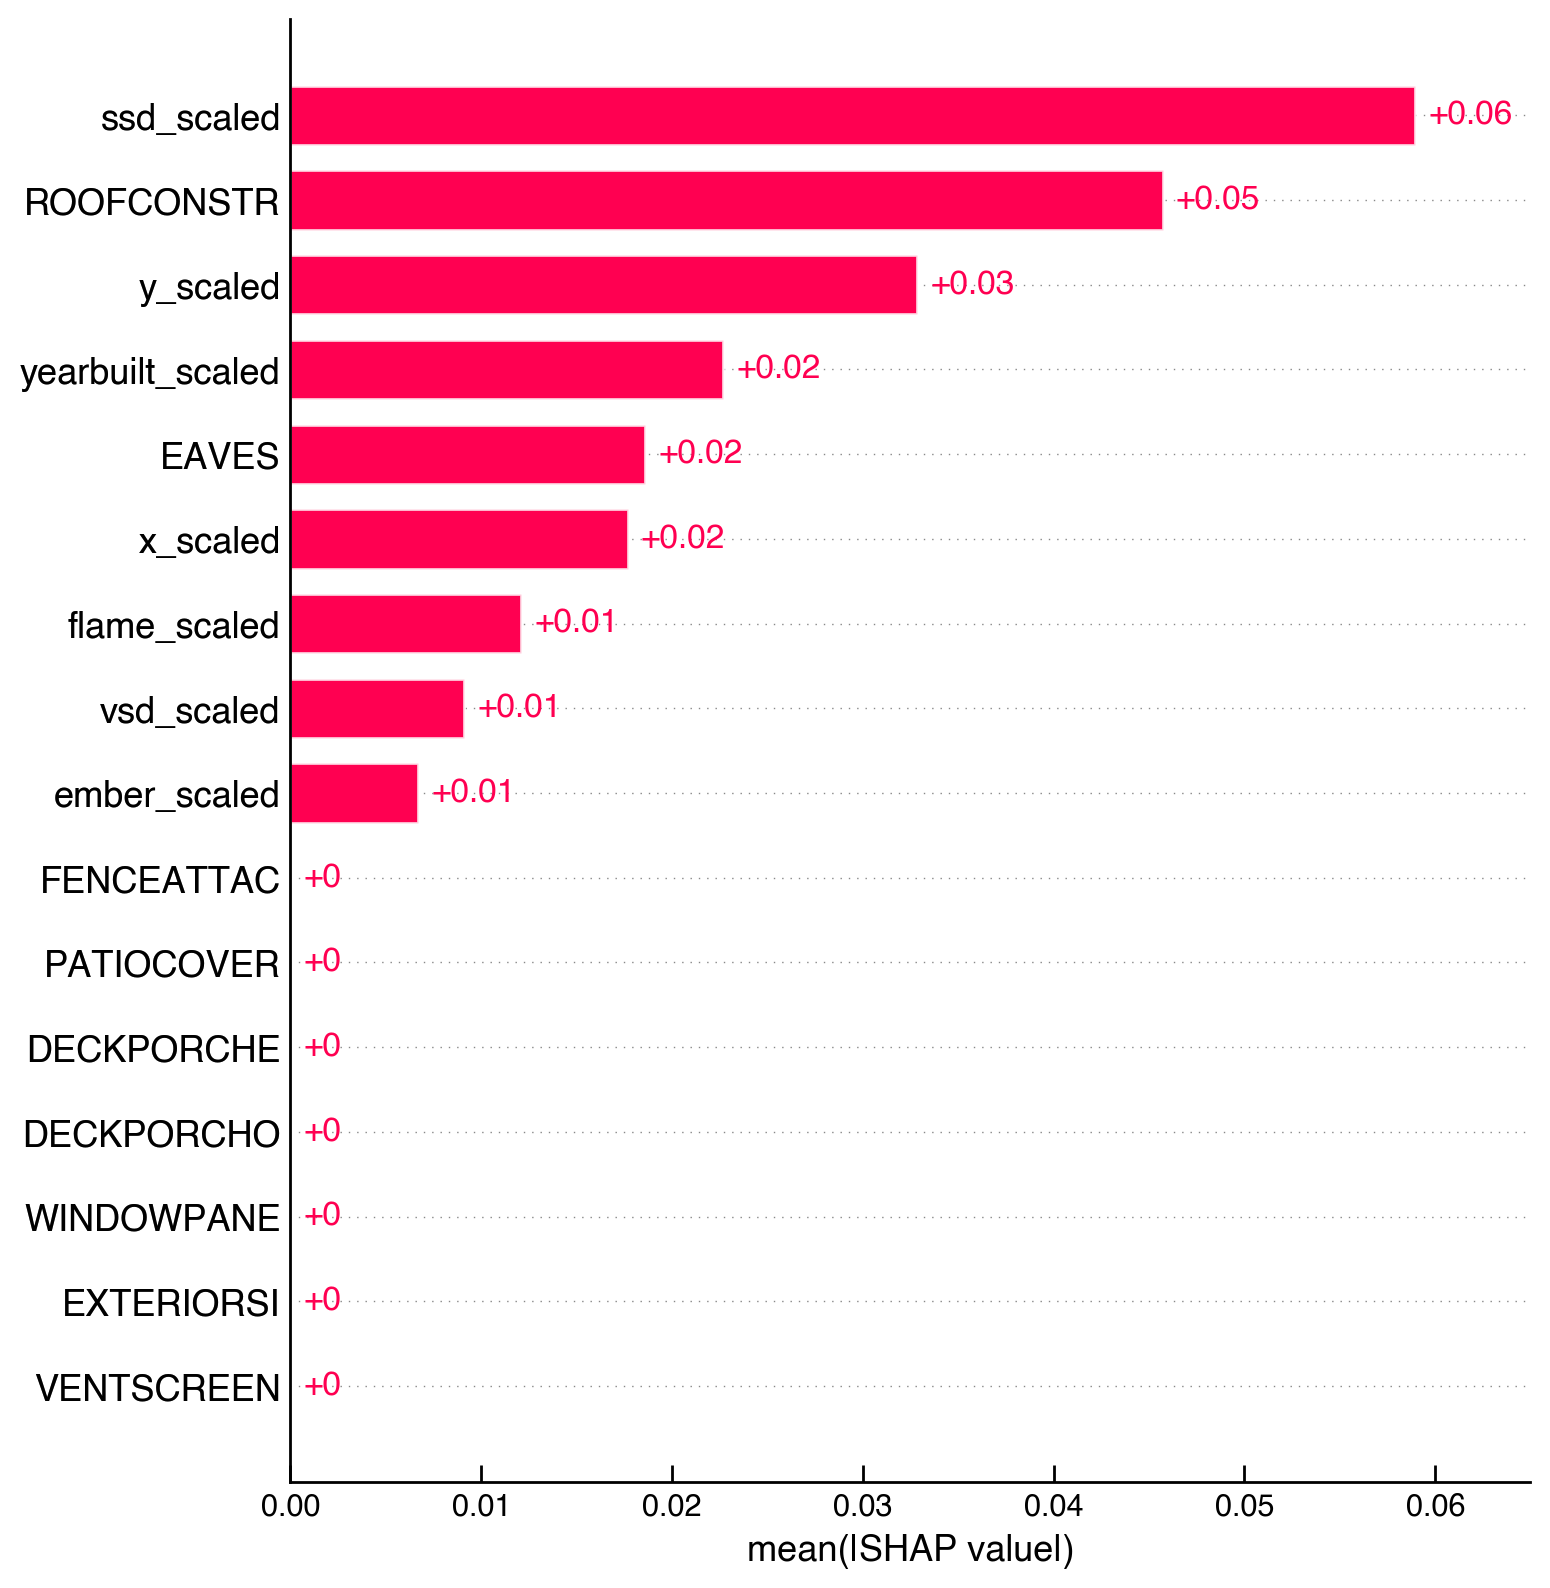

In [16]:
shap.plots.bar(nsh, max_display=16)